# Demo 04: Ray Tracing and Sensitivity Kernels on 1D Spherical Meshes

This notebook demonstrates ray tracing and sensitivity kernel computation using **1D spherical meshes** for radially-symmetric planet models. This is the 1D equivalent of demo 02, showcasing the same workflow but optimized for spherical symmetry.

**Key Features:**
- Generate 1D spherical meshes (faster and simpler than 3D tetrahedral)
- Compute ray path lengths through spherical shells
- Calculate sensitivity kernels for seismic properties
- Visualize radial profiles using `plot_shell_property()`
- Process single and multiple rays with the same unified API

In [1]:
# Setup: Enable/disable interactive plotting
INTERACTIVE = True  # Set to False for batch processing

import sys
import numpy as np
import matplotlib.pyplot as plt

# Import SensRay
sys.path.insert(0, '../')
from sensray import PlanetModel

print("SensRay loaded successfully!")
print(f"Interactive mode: {INTERACTIVE}")

/home/adrian/miniconda3/envs/masters/lib/python3.11/site-packages/obspy/core/util/base.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


SensRay loaded successfully!
Interactive mode: True


## 1. Create Planet Model and 1D Spherical Mesh

We'll use the PREM model and create a 1D spherical mesh with major discontinuities.

In [2]:
# Load PREM model
model = PlanetModel.from_standard_model("prem")
print(f"Loaded model: {model.name}")
print(f"Radius: {model.radius} km")

# Define layer boundaries with variable spacing
# PREM discontinuities: ICB at 1221.5 km, CMB at 3480 km, surface at 6371 km
ICB_radius = 1221.5  # Inner core boundary
CMB_radius = 3480.0  # Core-mantle boundary

# Inner core: uniform spacing (e.g., 100 km)
dr_inner_core = 100.0
radii_inner_core = np.arange(0, ICB_radius, dr_inner_core)

# Outer core: uniform spacing (e.g., 150 km)
dr_outer_core = 150.0
radii_outer_core = np.arange(ICB_radius, CMB_radius, dr_outer_core)

# Mantle: increasing spacing from bottom to top
# Small spacing near CMB (lower mantle), larger spacing near surface (upper mantle)
n_mantle = 20  # Number of layers in mantle
# Create increasing spacing using quadratic progression
spacing_factor = np.linspace(1, 3, n_mantle)  # Increases from 1x to 3x
cumulative_thickness = np.cumsum(spacing_factor)
cumulative_thickness = np.flip(cumulative_thickness) / cumulative_thickness[-1] * (model.radius - CMB_radius)
radii_mantle = CMB_radius + cumulative_thickness

# Combine all radii (in descending order for mesh generation)
radii = np.concatenate([radii_inner_core, radii_outer_core, radii_mantle, [model.radius]])
radii = np.unique(radii)  # Remove any duplicates
radii = radii[::-1]  # Reverse to descending order

print(f"\nRadii spacing:")
print(f"  Inner core: {len(radii_inner_core)} layers, dr = {dr_inner_core} km")
print(f"  Outer core: {len(radii_outer_core)} layers, dr = {dr_outer_core} km")
print(f"  Mantle: {len(radii_mantle)} layers, variable spacing")
print(f"  Total boundaries: {len(radii)}")

print(f"\nGenerating 1D spherical mesh with {len(radii)} boundaries...")
model.mesh.generate_spherical_mesh(radii=radii)
print(f"Created mesh with {model.mesh.mesh.n_cells} layers")

Loaded model: PREM
Radius: 6371.0 km

Radii spacing:
  Inner core: 13 layers, dr = 100.0 km
  Outer core: 16 layers, dr = 150.0 km
  Mantle: 20 layers, variable spacing
  Total boundaries: 49

Generating 1D spherical mesh with 49 boundaries...
Generated spherical mesh: 48 layers, 49 boundaries
Created mesh with 48 layers


## 2. Populate Mesh with Seismic Properties

Map properties from the continuous model onto the discrete 1D mesh cells.

In [3]:
# Populate properties using volume-weighted radial integration
model.mesh.populate_properties(['vp', 'vs', 'rho'])

# Verify properties are stored
print("Properties in mesh.cell_data:")
for prop in ['vp', 'vs', 'rho']:
    values = model.mesh.mesh.cell_data[prop]
    print(f"  {prop}: {len(values)} values, range [{values.min():.2f}, {values.max():.2f}]")

/home/adrian/PhD/masters/SensRay/demos/../sensray/planet_mesh.py:1089: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(


Populated properties: ['vp', 'vs', 'rho']
Properties in mesh.cell_data:
  vp: 48 values, range [7.84, 13.69]
  vs: 48 values, range [0.00, 7.27]
  rho: 48 values, range [3.29, 13.09]


## 3. Visualize Properties on 1D Mesh

Use `plot_shell_property()` to visualize radial profiles.

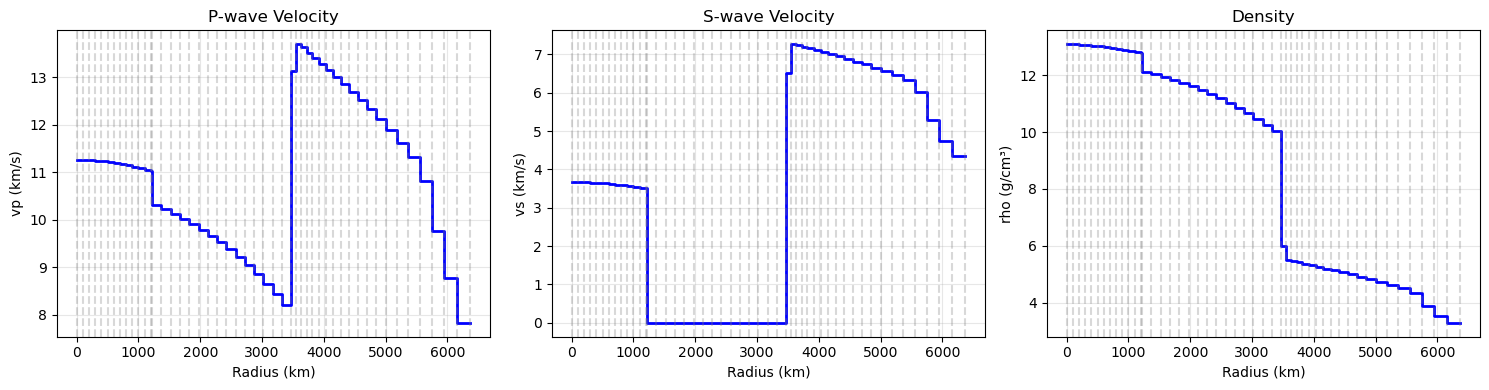

In [4]:
# Plot velocity profiles
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, prop, title in zip(axes, ['vp', 'vs', 'rho'], ['P-wave Velocity', 'S-wave Velocity', 'Density']):
    radii = model.mesh.mesh.radii
    values = model.mesh.mesh.cell_data[prop]

    # Create step plot
    r_plot = []
    v_plot = []
    for i in range(len(values)):
        r_plot.extend([radii[i], radii[i+1]])
        v_plot.extend([values[i], values[i]])

    ax.plot(r_plot, v_plot, 'b-', linewidth=2)
    ax.set_xlabel('Radius (km)')
    ax.set_ylabel(f'{prop} ({["km/s", "km/s", "g/cm³"][["vp", "vs", "rho"].index(prop)]})')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    # Add vertical lines at boundaries
    for r in radii:
        ax.axvline(r, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
if INTERACTIVE:
    plt.show()
else:
    plt.close()

## 4. Define Source-Receiver Geometry

Set up seismic source and receiver for ray tracing.

In [5]:
# Source and receiver parameters
source_depth_km = 10.0  # Shallow earthquake
distance_deg = 60.0     # Epicentral distance

print(f"Source depth: {source_depth_km} km")
print(f"Epicentral distance: {distance_deg}°")

Source depth: 10.0 km
Epicentral distance: 60.0°


## 5. Compute Ray Paths with TauP

Calculate ray paths for P, S, and ScS phases.

In [6]:
# Compute ray paths for multiple phases
phases = ['P', 'S', 'ScS']
rays_dict = {}

print("Computing ray paths...")
for phase in phases:
    rays = model.taupy_model.get_ray_paths(
        source_depth_in_km=source_depth_km,
        distance_in_degree=distance_deg,
        phase_list=[phase]
    )
    if rays:
        rays_dict[phase] = rays[0]  # Take first arrival
        print(f"  {phase}: {len(rays[0].path)} points, travel time = {rays[0].time:.2f} s")
    else:
        print(f"  {phase}: No rays found")

print(f"\nTotal phases with rays: {len(rays_dict)}")

Computing ray paths...
Building obspy.taup model for '/home/adrian/PhD/masters/SensRay/sensray/models/prem.nd' ...
filename = /home/adrian/PhD/masters/SensRay/sensray/models/prem.nd
Done reading velocity model.
Radius of model . is 6371.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  553 P layers,646 S layers
Done calculating Tau branches.
Done Saving /tmp/prem.npz
Method run is done, but not necessarily successful.
  P: 272 points, travel time = 605.54 s
  S: 364 points, travel time = 1099.28 s
  ScS: 538 points, travel time = 1196.76 s

Total phases with rays: 3


## 6. Compute Ray Path Lengths Through Layers

Use the consolidated `compute_ray_lengths()` API that works for both 1D and 3D meshes.

In [7]:
# Compute path lengths for each phase
lengths_dict = {}

for phase, ray in rays_dict.items():
    lengths = model.mesh.compute_ray_lengths(ray, store_as=f'{phase}_lengths')
    lengths_dict[phase] = lengths
    print(f"{phase} path lengths: total = {lengths.sum():.2f} km, "
          f"max in layer = {lengths.max():.2f} km")

Stored ray path lengths as cell data: 'P_lengths'
P path lengths: total = 6599.47 km, max in layer = 1345.70 km
Stored ray path lengths as cell data: 'S_lengths'
S path lengths: total = 6565.03 km, max in layer = 1737.75 km
Stored ray path lengths as cell data: 'ScS_lengths'
ScS path lengths: total = 7578.45 km, max in layer = 443.89 km


## 7. Visualize Ray Path Lengths

Plot radial profiles showing how much each ray passes through each layer.

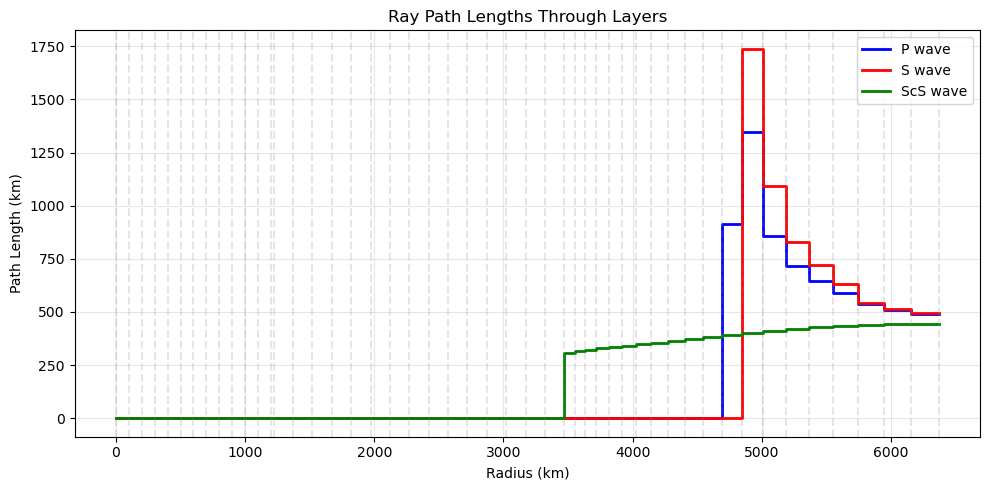

In [8]:
# Plot path lengths for all phases
fig, ax = plt.subplots(figsize=(10, 5))

radii = model.mesh.mesh.radii
colors = {'P': 'blue', 'S': 'red', 'ScS': 'green'}

for phase in phases:
    if phase in lengths_dict:
        lengths = lengths_dict[phase]

        # Create step plot
        r_plot = []
        l_plot = []
        for i in range(len(lengths)):
            r_plot.extend([radii[i], radii[i+1]])
            l_plot.extend([lengths[i], lengths[i]])

        ax.plot(r_plot, l_plot, label=f'{phase} wave',
                color=colors.get(phase, 'gray'), linewidth=2)

ax.set_xlabel('Radius (km)')
ax.set_ylabel('Path Length (km)')
ax.set_title('Ray Path Lengths Through Layers')
ax.legend()
ax.grid(True, alpha=0.3)

# Add vertical lines at boundaries
for r in radii:
    ax.axvline(r, color='gray', linestyle='--', alpha=0.2)

plt.tight_layout()
if INTERACTIVE:
    plt.show()
else:
    plt.close()

## 8. Compute Sensitivity Kernels for Single Rays

Calculate sensitivity kernels K = -L/v² for velocity perturbations.

In [9]:
# Compute sensitivity kernels for P and S waves
kernels_dict = {}

for phase, ray in rays_dict.items():
    if phase in ['P', 'S']:  # P uses vp, S uses vs
        property_name = 'vp' if phase == 'P' else 'vs'
        kernel = model.mesh.compute_sensitivity_kernel(
            ray,
            property_name=property_name,
            attach_name=f'K_{phase}'
        )
        kernels_dict[phase] = kernel
        print(f"{phase} kernel: min = {kernel.min():.3e}, max = {kernel.max():.3e}")

Stored sensitivity kernel as cell data: 'K_P'
P kernel: min = -9.166e+00, max = -0.000e+00
Stored sensitivity kernel as cell data: 'K_S'
S kernel: min = -3.923e+01, max = -0.000e+00


## 9. Visualize Sensitivity Kernels

Plot the kernels to see which layers contribute most to travel time perturbations.

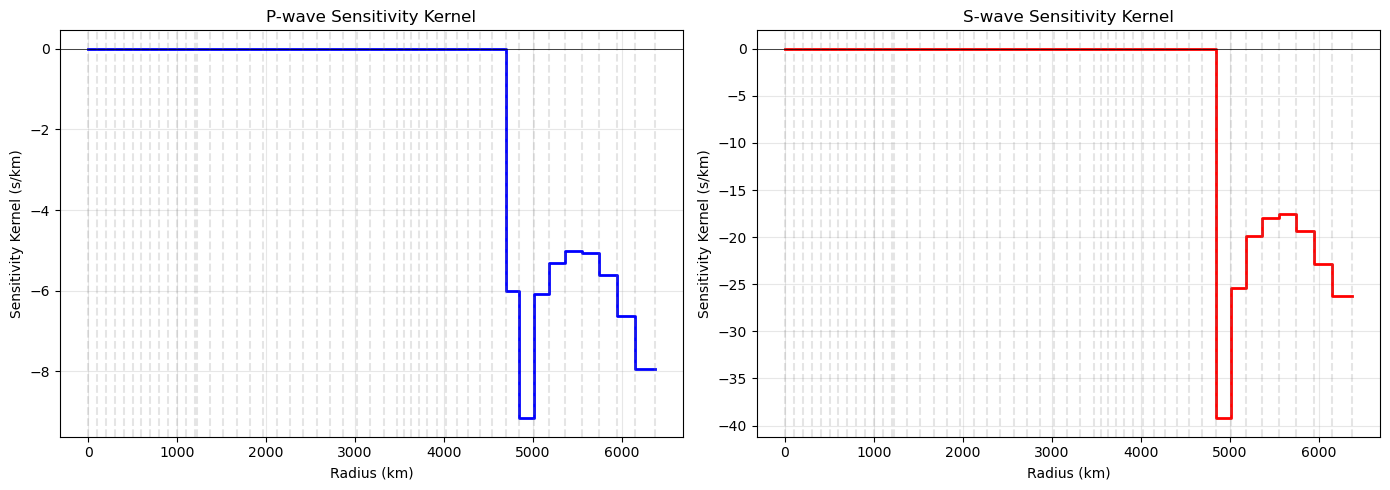

In [10]:
# Plot sensitivity kernels
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, phase in zip(axes, ['P', 'S']):
    if phase in kernels_dict:
        kernel = kernels_dict[phase]
        radii = model.mesh.mesh.radii

        # Create step plot
        r_plot = []
        k_plot = []
        for i in range(len(kernel)):
            r_plot.extend([radii[i], radii[i+1]])
            k_plot.extend([kernel[i], kernel[i]])

        ax.plot(r_plot, k_plot, color=colors.get(phase, 'gray'), linewidth=2)
        ax.set_xlabel('Radius (km)')
        ax.set_ylabel('Sensitivity Kernel (s/km)')
        ax.set_title(f'{phase}-wave Sensitivity Kernel')
        ax.grid(True, alpha=0.3)

        # Add vertical lines at boundaries
        for r in radii:
            ax.axvline(r, color='gray', linestyle='--', alpha=0.2)

        # Add zero line
        ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
if INTERACTIVE:
    plt.show()
else:
    plt.close()

## 10. Process Multiple Rays Together

Use the consolidated API to compute kernels for multiple rays at once.

In [11]:
# Compute multiple P-wave rays at different distances
distances = [30, 60, 90]
p_rays = []

print("Computing P-wave rays at multiple distances:")
for dist in distances:
    rays = model.taupy_model.get_ray_paths(
        source_depth_in_km=source_depth_km,
        distance_in_degree=dist,
        phase_list=['P']
    )
    if rays:
        p_rays.append(rays[0])
        print(f"  {dist}°: {len(rays[0].path)} points, time = {rays[0].time:.2f} s")

print(f"\nTotal P-wave rays: {len(p_rays)}")

Computing P-wave rays at multiple distances:
  30°: 168 points, time = 368.05 s
  60°: 272 points, time = 605.54 s
  90°: 366 points, time = 778.01 s

Total P-wave rays: 3


## 11. Compute Accumulated Sensitivity Kernel

Sum kernels from multiple rays to see overall sensitivity pattern.

In [12]:
# Compute summed kernel using accumulate='sum'
K_sum = model.mesh.compute_sensitivity_kernel(
    p_rays,
    property_name='vp',
    attach_name='K_P_sum',
    accumulate='sum'
)

print(f"Accumulated kernel: shape = {K_sum.shape}, "
      f"sum = {K_sum.sum():.3e}, "
      f"range = [{K_sum.min():.3e}, {K_sum.max():.3e}]")

# Also compute individual kernels for comparison
K_individual = model.mesh.compute_sensitivity_kernel(
    p_rays,
    property_name='vp',
    accumulate=None  # Returns 2D array
)

print(f"Individual kernels: shape = {K_individual.shape}")

Stored summed sensitivity kernel as cell data: 'K_P_sum'
Accumulated kernel: shape = (48,), sum = -1.632e+02, range = [-2.427e+01, 0.000e+00]
Individual kernels: shape = (3, 48)


## 12. Visualize Individual vs Accumulated Kernels

Compare individual ray kernels with their sum.

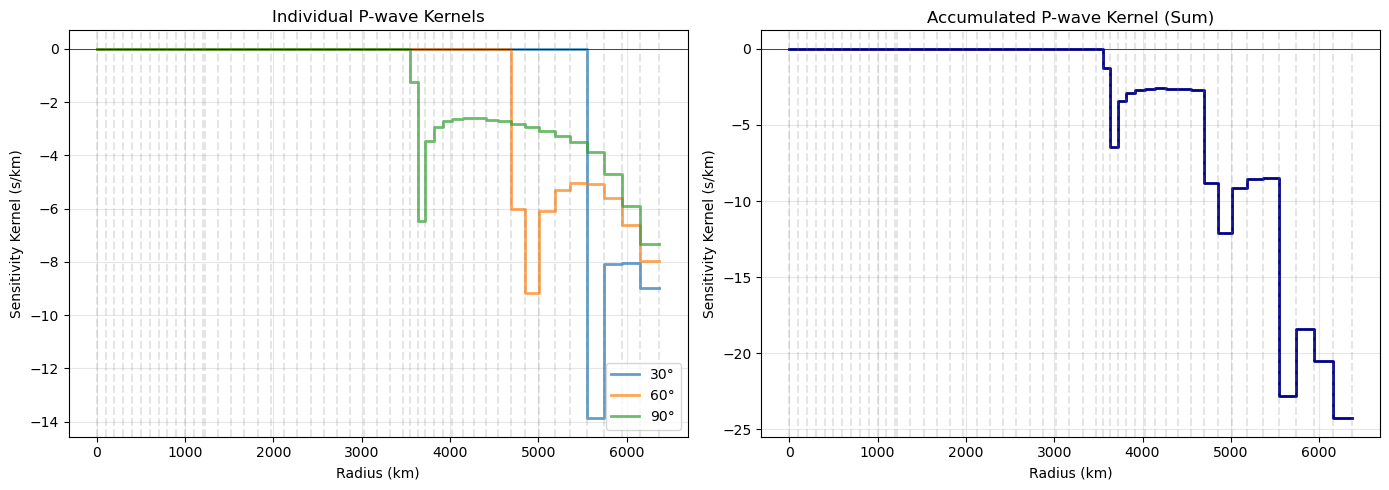

In [13]:
# Plot individual and summed kernels
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

radii = model.mesh.mesh.radii

# Left: individual kernels
ax = axes[0]
for i, dist in enumerate(distances):
    kernel = K_individual[i]

    # Create step plot
    r_plot = []
    k_plot = []
    for j in range(len(kernel)):
        r_plot.extend([radii[j], radii[j+1]])
        k_plot.extend([kernel[j], kernel[j]])

    ax.plot(r_plot, k_plot, label=f'{dist}°', linewidth=2, alpha=0.7)

ax.set_xlabel('Radius (km)')
ax.set_ylabel('Sensitivity Kernel (s/km)')
ax.set_title('Individual P-wave Kernels')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

# Right: accumulated kernel
ax = axes[1]
r_plot = []
k_plot = []
for i in range(len(K_sum)):
    r_plot.extend([radii[i], radii[i+1]])
    k_plot.extend([K_sum[i], K_sum[i]])

ax.plot(r_plot, k_plot, color='darkblue', linewidth=2)
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Sensitivity Kernel (s/km)')
ax.set_title('Accumulated P-wave Kernel (Sum)')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

# Add boundaries
for ax in axes:
    for r in radii:
        ax.axvline(r, color='gray', linestyle='--', alpha=0.2)

plt.tight_layout()
if INTERACTIVE:
    plt.show()
else:
    plt.close()

## 13. Save Mesh with All Computed Data

Export the mesh with all properties, ray lengths, and kernels.

In [14]:
# List all computed properties
print("Properties stored in mesh:")
model.mesh.list_properties(show_stats=True, top_n=5)

# Save mesh
output_path = "prem_spherical_mesh_with_rays_kernels"
model.mesh.save(output_path)
print(f"\nMesh saved to {output_path}.*")

Properties stored in mesh:
Mesh properties summary:
  cell_data keys: ['vp', 'vs', 'rho', 'P_lengths', 'S_lengths', 'ScS_lengths', 'K_P', 'K_S', 'K_P_sum']

Cell property summaries (first entries):
 - vp: min=7.835577011108398, max=13.689336776733398, non_zero=48
 - vs: min=0.0, max=7.265659332275391, non_zero=33
 - rho: min=3.2944087982177734, max=13.086845397949219, non_zero=48
 - P_lengths: min=0.0, max=1345.6966552734375, non_zero=9
 - S_lengths: min=0.0, max=1737.7496337890625, non_zero=8
 - ScS_lengths: min=0.0, max=443.8861389160156, non_zero=20
 - K_P: min=-9.165626525878906, max=-0.0, non_zero=9
 - K_S: min=-39.22964859008789, max=-0.0, non_zero=8
 - K_P_sum: min=-24.268333435058594, max=0.0, non_zero=19
Saved mesh to prem_spherical_mesh_with_rays_kernels.npz
Saved metadata to prem_spherical_mesh_with_rays_kernels_metadata.json

Mesh saved to prem_spherical_mesh_with_rays_kernels.*


## Summary

This notebook demonstrated:

1. **1D Spherical Mesh Generation**: Fast and simple for radially-symmetric models
2. **Property Mapping**: Volume-weighted integration from continuous model to discrete layers
3. **Ray Tracing**: Works identically to 3D meshes using the same API
4. **Path Lengths**: Exact geometric intersection with spherical shells
5. **Sensitivity Kernels**: K = -L/v² computation for single and multiple rays
6. **Consolidated API**: Same methods work for both 1D and 3D meshes
   - `compute_ray_lengths()`: single or multiple rays automatically
   - `compute_sensitivity_kernel()`: with `accumulate` parameter for summing

**Advantages of 1D Spherical Meshes:**
- Much faster than 3D tetrahedral meshes
- Simpler visualization (radial profiles vs 3D cross-sections)
- Perfect for testing and radially-symmetric problems
- Identical API to 3D meshes (seamless workflow)